# Baseline

## Imports

In [1]:
# Colab
from google.colab import drive

# Utilities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random
import os

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split

# PyTorch
import torch
from torch import no_grad, max
from torch.cuda import is_available
from torch.utils.data import DataLoader, Subset, Dataset
from torch.optim import Adam
from torch.amp.grad_scaler import GradScaler
from torch.amp import autocast
from torch.nn import CrossEntropyLoss

# Torchvision
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.models.densenet import densenet121, DenseNet121_Weights
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

## Setup device and load Google Drive data

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/images.zip -d /content/images/

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/ISIC_0068028.jpg  
  inflating: /content/images/ISIC_0068029.jpg  
  inflating: /content/images/ISIC_0068030.jpg  
  inflating: /content/images/ISIC_0068031.jpg  
  inflating: /content/images/ISIC_0068032.jpg  
  inflating: /content/images/ISIC_0068033.jpg  
  inflating: /content/images/ISIC_0068034.jpg  
  inflating: /content/images/ISIC_0068035.jpg  
  inflating: /content/images/ISIC_0068036.jpg  
  inflating: /content/images/ISIC_0068037.jpg  
  inflating: /content/images/ISIC_0068038.jpg  
  inflating: /content/images/ISIC_0068039.jpg  
  inflating: /content/images/ISIC_0068040.jpg  
  inflating: /content/images/ISIC_0068041.jpg  
  inflating: /content/images/ISIC_0068042.jpg  
  inflating: /content/images/ISIC_0068043.jpg  
  inflating: /content/images/ISIC_0068044.jpg  
  inflating: /content/images/ISIC_0068045.jpg  
  inflating: /content/images/ISIC_0068046.jpg  
  inflating: /content/images/ISIC_006

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
!find /content/images -type f | wc -l

18947


## Load BCN20000 metadata

Podział klas:
benign_malignant
benign       5647
malignant    4003
Name: count, dtype: int64


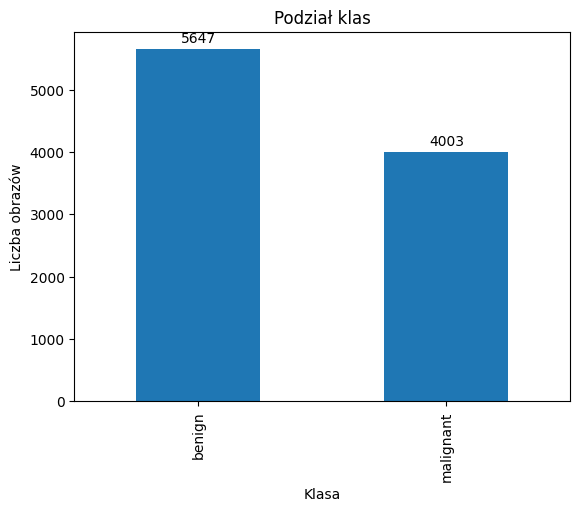

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Praca magisterska/Dane/BCN20000/bcn20000_metadata_2025-05-15.csv')

df = df.dropna(subset=['benign_malignant'])
df = df.reset_index(drop=True)
print("Podział klas:")
print(df['benign_malignant'].value_counts())

value_counts = df['benign_malignant'].value_counts()
ax = value_counts.plot(kind='bar', title='Podział klas')

plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')

for i, value in enumerate(value_counts):
    ax.text(i, value + value_counts.max() * 0.01, str(value), ha='center', va='bottom')

plt.show()

## Data loader

In [7]:
class BCNDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {'benign': 0, 'malignant': 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['isic_id']
        label = self.label_map[row['benign_malignant']]
        image_path = os.path.join(self.img_dir, f"{image_id}.jpg")
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

BATCH_SIZE = 32
IMG_DIR = '/content/images'

## Example data

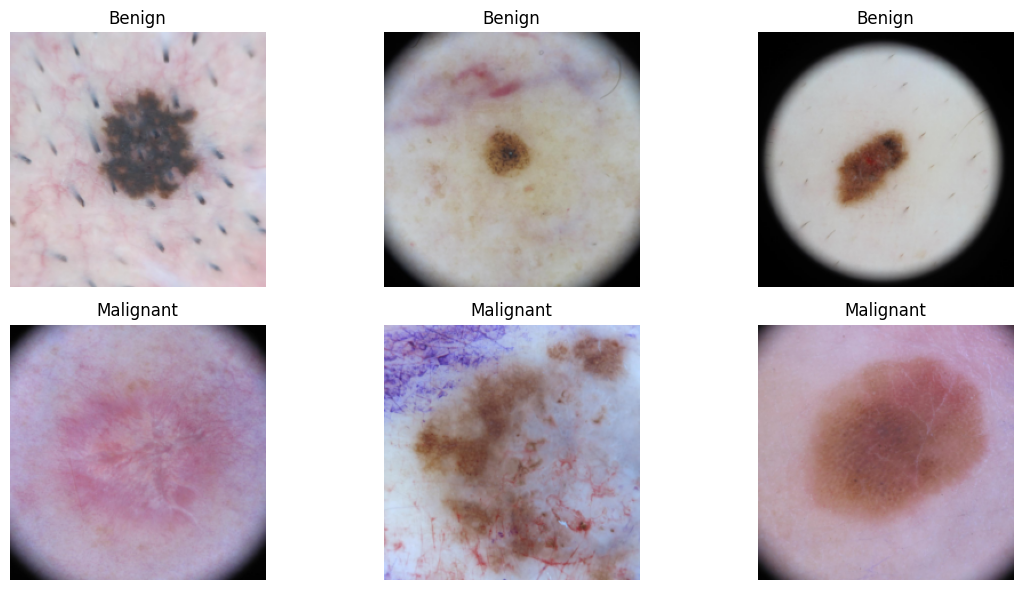

In [8]:
example_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

example_dataset = BCNDataset(df, IMG_DIR, example_transform)

example_loader = DataLoader(example_dataset, batch_size=BATCH_SIZE)
benign_idx = [i for i, row in example_dataset.df.iterrows() if row['benign_malignant'] == 'benign']
malignant_idx = [i for i, row in example_dataset.df.iterrows() if row['benign_malignant'] == 'malignant']

samples = random.sample(benign_idx, 3) + random.sample(malignant_idx, 3)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax, idx in zip(axs.flatten(), samples):
    image, label = example_dataset[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.axis('off')
    ax.set_title('Benign' if label == 0 else 'Malignant')

plt.tight_layout()
plt.show()

## Helper function for calculating metrics

In [9]:
def calculate_accuracy(loader, model, device):
    model.eval()
    with no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def calculate_metrics(loader, model, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, precision, recall, f1

## Training loop

In [10]:
def training_loop(architecture, df, num_of_epochs, train_transform, weights=None):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    models = []
    test_accuracies = []

    eval_log = []

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    X = df.index.values
    y = df['benign_malignant'].map({'benign': 0, 'malignant': 1}).values

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        model = architecture(weights=weights if weights else None)
        arch_name = type(model).__name__.lower()

        if weights:
            if 'resnet' in arch_name:
                num_features = model.fc.in_features
                model.fc = torch.nn.Linear(num_features, 2)
                for param in model.parameters():
                    param.requires_grad = False
                for param in model.fc.parameters():
                    param.requires_grad = True
            elif 'densenet' in arch_name:
                num_features = model.classifier.in_features
                model.classifier = torch.nn.Linear(num_features, 2)
                for param in model.parameters():
                    param.requires_grad = False
                for param in model.classifier.parameters():
                    param.requires_grad = True
            elif 'visiontransformer' in arch_name:
                model.heads.head = torch.nn.Linear(model.heads.head.in_features, 2)
                for param in model.parameters():
                    param.requires_grad = False
                for param in model.heads.head.parameters():
                    param.requires_grad = True
            else:
                raise ValueError(f"Unsupported architecture: {arch_name}")
        else:
            if 'resnet' in arch_name:
                num_features = model.fc.in_features
                model.fc = torch.nn.Linear(num_features, 2)
            elif 'densenet' in arch_name:
                num_features = model.classifier.in_features
                model.classifier = torch.nn.Linear(num_features, 2)
            elif 'visiontransformer' in arch_name:
                model.heads.head = torch.nn.Linear(model.heads.head.in_features, 2)
            else:
                raise ValueError(f"Unsupported architecture: {arch_name}")

        print(f"FOLD {fold+1}")

        train_subset = df.iloc[train_index].reset_index(drop=True)
        val_subset = df.iloc[val_index].reset_index(drop=True)

        train_dataset = BCNDataset(train_subset, IMG_DIR, train_transform)
        val_dataset = BCNDataset(val_subset, IMG_DIR, val_transform)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model = model.to(device)
        criterion = CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=0.001)
        scaler = GradScaler()

        fold_log = {
            "fold": fold + 1,
            "train_loss": [],
            "val_acc": [],
            "val_precision": None,
            "val_recall": None,
            "val_f1": None
        }

        for epoch in range(num_of_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                with autocast(device.type):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)
            val_accuracy = calculate_accuracy(val_loader, model, device)

            fold_log["train_loss"].append(train_loss)
            fold_log["val_acc"].append(val_accuracy)

            print(f'Epoch [{epoch+1}/{num_of_epochs}], Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        val_acc, val_prec, val_recall, val_f1 = calculate_metrics(val_loader, model, device)
        fold_log.update({
            "val_acc": val_acc,
            "val_precision": val_prec,
            "val_recall": val_recall,
            "val_f1": val_f1
        })

        test_accuracies.append(val_acc)
        models.append(model)
        eval_log.append(fold_log)

        print(f"Fold {fold+1} -  Val Accuracy: {val_acc:.2f}% | Precision: {val_prec:.2f} | Recall: {val_recall:.2f} | F1: {val_f1:.2f}")

    best_model_idx = np.argmax(test_accuracies)
    best_model = models[best_model_idx]
    print(f'Best model validation accuracy: {test_accuracies[best_model_idx]:.2f}%')
    return best_model, eval_log

## Run training

### Train transform (without augmentation)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### ResNet

In [ ]:
resnet, resnet_eval = training_loop(architecture=resnet50, df=df, num_of_epochs=25, train_transform=transform)

FOLD 1
Epoch [1/25], Loss: 0.6411, Validation Accuracy: 65.28%
Epoch [2/25], Loss: 0.6005, Validation Accuracy: 68.33%
Epoch [3/25], Loss: 0.5900, Validation Accuracy: 68.13%
Epoch [4/25], Loss: 0.5686, Validation Accuracy: 64.64%
Epoch [5/25], Loss: 0.5689, Validation Accuracy: 67.42%
Epoch [6/25], Loss: 0.5600, Validation Accuracy: 70.01%
Epoch [7/25], Loss: 0.5430, Validation Accuracy: 66.84%
Epoch [8/25], Loss: 0.5473, Validation Accuracy: 72.09%
Epoch [9/25], Loss: 0.5324, Validation Accuracy: 76.42%
Epoch [10/25], Loss: 0.5225, Validation Accuracy: 76.88%
Epoch [11/25], Loss: 0.5116, Validation Accuracy: 75.06%
Epoch [12/25], Loss: 0.5092, Validation Accuracy: 75.06%
Epoch [13/25], Loss: 0.5144, Validation Accuracy: 76.04%
Epoch [14/25], Loss: 0.5053, Validation Accuracy: 78.11%
Epoch [15/25], Loss: 0.5032, Validation Accuracy: 77.98%
Epoch [16/25], Loss: 0.4986, Validation Accuracy: 78.43%
Epoch [17/25], Loss: 0.4980, Validation Accuracy: 79.53%
Epoch [18/25], Loss: 0.4927, Vali

In [ ]:
df_rn = pd.DataFrame(resnet_eval)
rn_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/rn_metrics.csv'
df_rn.to_csv(rn_csv_path)

In [ ]:
rn_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/rn.pt'
torch.save(resnet, rn_model_path)

### DenseNet

In [ ]:
densenet, densenet_eval = training_loop(architecture=densenet121, df=df, num_of_epochs=25, train_transform=transform)

FOLD 1
Epoch [1/25], Loss: 0.5966, Validation Accuracy: 71.05%
Epoch [2/25], Loss: 0.5687, Validation Accuracy: 71.31%
Epoch [3/25], Loss: 0.5562, Validation Accuracy: 72.93%
Epoch [4/25], Loss: 0.5509, Validation Accuracy: 75.00%
Epoch [5/25], Loss: 0.5403, Validation Accuracy: 75.19%
Epoch [6/25], Loss: 0.5323, Validation Accuracy: 71.05%
Epoch [7/25], Loss: 0.5248, Validation Accuracy: 76.94%
Epoch [8/25], Loss: 0.5233, Validation Accuracy: 77.27%
Epoch [9/25], Loss: 0.5199, Validation Accuracy: 75.32%
Epoch [10/25], Loss: 0.5191, Validation Accuracy: 76.81%
Epoch [11/25], Loss: 0.5092, Validation Accuracy: 76.23%
Epoch [12/25], Loss: 0.5082, Validation Accuracy: 73.83%
Epoch [13/25], Loss: 0.5091, Validation Accuracy: 76.30%
Epoch [14/25], Loss: 0.5033, Validation Accuracy: 74.55%
Epoch [15/25], Loss: 0.5022, Validation Accuracy: 78.17%
Epoch [16/25], Loss: 0.4955, Validation Accuracy: 78.43%
Epoch [17/25], Loss: 0.4930, Validation Accuracy: 77.40%
Epoch [18/25], Loss: 0.4932, Vali

In [ ]:
df_dn = pd.DataFrame(densenet_eval)
dn_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/dn_metrics.csv'
df_dn.to_csv(dn_csv_path)

In [ ]:
dn_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/dn.pt'
torch.save(densenet, dn_model_path)

### Vision Transformer

In [ ]:
vit, vit_eval = training_loop(architecture=vit_b_16, df=df, train_transform=transform, num_of_epochs=25, is_vit=True)

FOLD 1
Epoch [1/25], Loss: 0.8340, Validation Accuracy: 58.55%
Epoch [2/25], Loss: 0.6767, Validation Accuracy: 58.48%
Epoch [3/25], Loss: 0.6802, Validation Accuracy: 64.05%
Epoch [4/25], Loss: 0.6368, Validation Accuracy: 66.90%
Epoch [5/25], Loss: 0.6375, Validation Accuracy: 62.63%
Epoch [6/25], Loss: 0.6152, Validation Accuracy: 60.95%
Epoch [7/25], Loss: 0.6276, Validation Accuracy: 69.82%
Epoch [8/25], Loss: 0.6125, Validation Accuracy: 69.56%
Epoch [9/25], Loss: 0.5987, Validation Accuracy: 58.68%
Epoch [10/25], Loss: 0.6591, Validation Accuracy: 63.54%
Epoch [11/25], Loss: 0.6420, Validation Accuracy: 67.10%
Epoch [12/25], Loss: 0.6562, Validation Accuracy: 61.79%
Epoch [13/25], Loss: 0.6655, Validation Accuracy: 61.01%
Epoch [14/25], Loss: 0.6643, Validation Accuracy: 65.54%
Epoch [15/25], Loss: 0.6480, Validation Accuracy: 65.28%
Epoch [16/25], Loss: 0.6459, Validation Accuracy: 59.52%
Epoch [17/25], Loss: 0.6563, Validation Accuracy: 63.67%
Epoch [18/25], Loss: 0.6767, Vali

In [ ]:
df_vit = pd.DataFrame(vit_eval)
vit_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/vit_metrics.csv'
df_vit.to_csv(vit_csv_path)

In [ ]:
vit_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/vit.pt'
torch.save(vit, vit_model_path)

## Augment data

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=0
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Example data

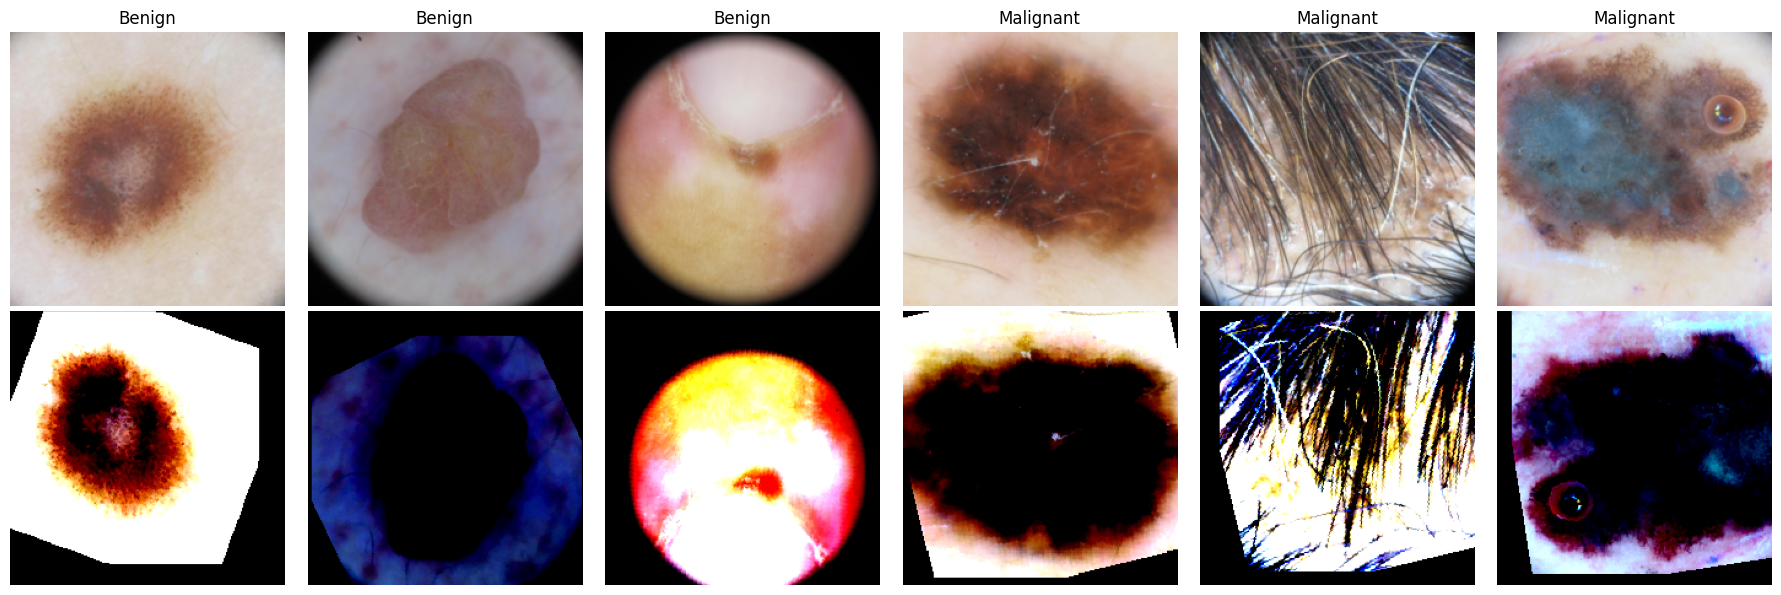

In [12]:
augmented_example_data = BCNDataset(df, IMG_DIR, transform=train_transforms)

benign_idx = [i for i, row in example_dataset.df.iterrows() if row['benign_malignant'] == 'benign']
malignant_idx = [i for i, row in example_dataset.df.iterrows() if row['benign_malignant'] == 'malignant']

samples = random.sample(benign_idx, 3) + random.sample(malignant_idx, 3)

fig, axs = plt.subplots(2, 6, figsize=(18, 6))

for i, idx in enumerate(samples):
    original_img, label = example_dataset[idx]
    axs[0, i].imshow(original_img.permute(1, 2, 0))
    axs[0, i].axis('off')
    axs[0, i].set_title('Benign' if label == 0 else 'Malignant')

    aug_img, _ = augmented_example_data[idx]
    axs[1, i].imshow(aug_img.permute(1, 2, 0))
    axs[1, i].axis('off')

axs[0, 0].set_ylabel('Original', fontsize=14)
axs[1, 0].set_ylabel('Augmented', fontsize=14)

plt.tight_layout()
plt.show()

## Run training

### ResNet

In [ ]:
aug_rn, aug_rn_eval = training_loop(architecture=resnet50, df=df, num_of_epochs=25, train_transform=train_transforms)

FOLD 1
Epoch [1/25], Loss: 0.7064, Validation Accuracy: 63.99%
Epoch [2/25], Loss: 0.6236, Validation Accuracy: 66.90%
Epoch [3/25], Loss: 0.6048, Validation Accuracy: 70.79%
Epoch [4/25], Loss: 0.5953, Validation Accuracy: 69.11%
Epoch [5/25], Loss: 0.5758, Validation Accuracy: 72.73%
Epoch [6/25], Loss: 0.5625, Validation Accuracy: 75.26%
Epoch [7/25], Loss: 0.5520, Validation Accuracy: 47.28%
Epoch [8/25], Loss: 0.5442, Validation Accuracy: 77.85%
Epoch [9/25], Loss: 0.5510, Validation Accuracy: 77.46%
Epoch [10/25], Loss: 0.5393, Validation Accuracy: 76.49%
Epoch [11/25], Loss: 0.5337, Validation Accuracy: 78.11%
Epoch [12/25], Loss: 0.5368, Validation Accuracy: 75.65%
Epoch [13/25], Loss: 0.5327, Validation Accuracy: 76.55%
Epoch [14/25], Loss: 0.5349, Validation Accuracy: 75.97%
Epoch [15/25], Loss: 0.5295, Validation Accuracy: 77.20%
Epoch [16/25], Loss: 0.5228, Validation Accuracy: 78.76%
Epoch [17/25], Loss: 0.5259, Validation Accuracy: 77.85%
Epoch [18/25], Loss: 0.5312, Vali

In [ ]:
df_rn_aug = pd.DataFrame(aug_rn_eval)
rn_aug_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/rn_aug_metrics.csv'
df_rn_aug.to_csv(rn_aug_csv_path)

In [ ]:
rn_aug_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/rn_aug.pt'
torch.save(aug_rn, rn_aug_model_path)

### DenseNet

In [ ]:
aug_dn, aug_dn_eval=training_loop(architecture=densenet121, df=df, num_of_epochs=25, train_transform=train_transforms)

FOLD 1
Epoch [1/25], Loss: 0.6370, Validation Accuracy: 67.62%
Epoch [2/25], Loss: 0.6004, Validation Accuracy: 72.54%
Epoch [3/25], Loss: 0.5843, Validation Accuracy: 70.08%
Epoch [4/25], Loss: 0.5700, Validation Accuracy: 72.41%
Epoch [5/25], Loss: 0.5666, Validation Accuracy: 67.81%
Epoch [6/25], Loss: 0.5679, Validation Accuracy: 75.32%
Epoch [7/25], Loss: 0.5530, Validation Accuracy: 77.85%
Epoch [8/25], Loss: 0.5584, Validation Accuracy: 77.46%
Epoch [9/25], Loss: 0.5432, Validation Accuracy: 76.55%
Epoch [10/25], Loss: 0.5429, Validation Accuracy: 76.10%
Epoch [11/25], Loss: 0.5443, Validation Accuracy: 77.33%
Epoch [12/25], Loss: 0.5439, Validation Accuracy: 76.30%
Epoch [13/25], Loss: 0.5366, Validation Accuracy: 72.73%
Epoch [14/25], Loss: 0.5332, Validation Accuracy: 76.62%
Epoch [15/25], Loss: 0.5278, Validation Accuracy: 78.63%
Epoch [16/25], Loss: 0.5342, Validation Accuracy: 78.69%
Epoch [17/25], Loss: 0.5252, Validation Accuracy: 78.76%
Epoch [18/25], Loss: 0.5319, Vali

In [ ]:
df_dn_aug = pd.DataFrame(aug_dn_eval)
dn_aug_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/dn_aug_metrics.csv'
df_dn_aug.to_csv(dn_aug_csv_path)

In [ ]:
dn_aug_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/dn_aug.pt'
torch.save(aug_dn, dn_aug_model_path)

### Vision Transformer

In [ ]:
aug_vit, aug_vit_eval = training_loop(architecture=vit_b_16, df=df, num_of_epochs=25, train_transform=train_transforms)

FOLD 1
Epoch [1/25], Loss: 0.8303, Validation Accuracy: 41.77%
Epoch [2/25], Loss: 0.6897, Validation Accuracy: 58.55%
Epoch [3/25], Loss: 0.6824, Validation Accuracy: 52.14%
Epoch [4/25], Loss: 0.6720, Validation Accuracy: 68.85%
Epoch [5/25], Loss: 0.6535, Validation Accuracy: 69.24%
Epoch [6/25], Loss: 0.6554, Validation Accuracy: 65.03%
Epoch [7/25], Loss: 0.6640, Validation Accuracy: 68.07%
Epoch [8/25], Loss: 0.6578, Validation Accuracy: 60.82%
Epoch [9/25], Loss: 0.6428, Validation Accuracy: 65.61%
Epoch [10/25], Loss: 0.6449, Validation Accuracy: 68.20%
Epoch [11/25], Loss: 0.6419, Validation Accuracy: 66.32%
Epoch [12/25], Loss: 0.6439, Validation Accuracy: 67.62%
Epoch [13/25], Loss: 0.6512, Validation Accuracy: 58.55%
Epoch [14/25], Loss: 0.6638, Validation Accuracy: 65.54%
Epoch [15/25], Loss: 0.6983, Validation Accuracy: 59.33%
Epoch [16/25], Loss: 0.6850, Validation Accuracy: 58.55%
Epoch [17/25], Loss: 0.6799, Validation Accuracy: 58.55%
Epoch [18/25], Loss: 0.6756, Vali

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 -  Test Accuracy: 58.50% | Precision: 0.34 | Recall: 0.58 | F1: 0.43
FOLD 5
Epoch [1/25], Loss: 0.8505, Validation Accuracy: 62.11%
Epoch [2/25], Loss: 0.6677, Validation Accuracy: 64.51%
Epoch [3/25], Loss: 0.6379, Validation Accuracy: 60.43%
Epoch [4/25], Loss: 0.6651, Validation Accuracy: 69.43%
Epoch [5/25], Loss: 0.6266, Validation Accuracy: 64.90%
Epoch [6/25], Loss: 0.6763, Validation Accuracy: 58.61%
Epoch [7/25], Loss: 0.6621, Validation Accuracy: 67.16%
Epoch [8/25], Loss: 0.6628, Validation Accuracy: 66.58%
Epoch [9/25], Loss: 0.6657, Validation Accuracy: 62.95%
Epoch [10/25], Loss: 0.6553, Validation Accuracy: 66.77%
Epoch [11/25], Loss: 0.6515, Validation Accuracy: 64.12%
Epoch [12/25], Loss: 0.6330, Validation Accuracy: 69.49%
Epoch [13/25], Loss: 0.6274, Validation Accuracy: 65.61%
Epoch [14/25], Loss: 0.6417, Validation Accuracy: 64.77%
Epoch [15/25], Loss: 0.6540, Validation Accuracy: 67.49%
Epoch [16/25], Loss: 0.6594, Validation Accuracy: 59.97%
Epoch [17/25],

In [ ]:
df_vit_aug = pd.DataFrame(aug_vit_eval)
vit_aug_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/vit_aug_metrics.csv'
df_vit_aug.to_csv(vit_aug_csv_path)

In [ ]:
vit_aug_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/vit_aug.pt'
torch.save(aug_vit, vit_aug_model_path)

## Transfer learning

### ResNet

In [ ]:
rn_ft, rn_ft_eval = training_loop(architecture=resnet50, df=df, num_of_epochs=15, train_transform=transform, weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 119MB/s]


FOLD 1
Epoch [1/15], Loss: 0.5096, Validation Accuracy: 80.18%
Epoch [2/15], Loss: 0.4631, Validation Accuracy: 81.35%
Epoch [3/15], Loss: 0.4344, Validation Accuracy: 81.22%
Epoch [4/15], Loss: 0.4235, Validation Accuracy: 80.38%
Epoch [5/15], Loss: 0.4163, Validation Accuracy: 81.35%
Epoch [6/15], Loss: 0.4066, Validation Accuracy: 82.38%
Epoch [7/15], Loss: 0.3927, Validation Accuracy: 82.06%
Epoch [8/15], Loss: 0.3924, Validation Accuracy: 82.38%
Epoch [9/15], Loss: 0.3864, Validation Accuracy: 81.09%
Epoch [10/15], Loss: 0.3825, Validation Accuracy: 81.28%
Epoch [11/15], Loss: 0.3739, Validation Accuracy: 81.35%
Epoch [12/15], Loss: 0.3713, Validation Accuracy: 81.87%
Epoch [13/15], Loss: 0.3708, Validation Accuracy: 81.48%
Epoch [14/15], Loss: 0.3696, Validation Accuracy: 81.80%
Epoch [15/15], Loss: 0.3679, Validation Accuracy: 81.35%
Fold 1 -  Test Accuracy: 82.18% | Precision: 0.82 | Recall: 0.82 | F1: 0.82
FOLD 2
Epoch [1/15], Loss: 0.5151, Validation Accuracy: 80.25%
Epoch [2

In [ ]:
df_rn_ft = pd.DataFrame(rn_ft_eval)
rn_ft_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/rn_ft_metrics.csv'
df_rn_ft.to_csv(rn_ft_csv_path)

In [ ]:
rn_ft_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/rn_ft.pt'
torch.save(rn_ft, rn_ft_model_path)

### DenseNet

In [ ]:
dn_ft, dn_ft_eval = training_loop(architecture=densenet121, df=df, num_of_epochs=15, train_transform=transform, weights=DenseNet121_Weights.IMAGENET1K_V1)

FOLD 1
Epoch [1/15], Loss: 0.5201, Validation Accuracy: 80.70%
Epoch [2/15], Loss: 0.4678, Validation Accuracy: 82.12%
Epoch [3/15], Loss: 0.4483, Validation Accuracy: 82.77%
Epoch [4/15], Loss: 0.4493, Validation Accuracy: 81.02%
Epoch [5/15], Loss: 0.4352, Validation Accuracy: 83.23%
Epoch [6/15], Loss: 0.4403, Validation Accuracy: 82.77%
Epoch [7/15], Loss: 0.4287, Validation Accuracy: 80.38%
Epoch [8/15], Loss: 0.4391, Validation Accuracy: 82.58%
Epoch [9/15], Loss: 0.4307, Validation Accuracy: 81.54%
Epoch [10/15], Loss: 0.4279, Validation Accuracy: 81.99%
Epoch [11/15], Loss: 0.4218, Validation Accuracy: 83.03%
Epoch [12/15], Loss: 0.4202, Validation Accuracy: 82.51%
Epoch [13/15], Loss: 0.4280, Validation Accuracy: 81.67%
Epoch [14/15], Loss: 0.4154, Validation Accuracy: 82.12%
Epoch [15/15], Loss: 0.4122, Validation Accuracy: 81.15%
Fold 1 -  Test Accuracy: 82.44% | Precision: 0.83 | Recall: 0.82 | F1: 0.82
FOLD 2
Epoch [1/15], Loss: 0.5141, Validation Accuracy: 80.57%
Epoch [2

In [ ]:
df_dn_ft = pd.DataFrame(dn_ft_eval)
dn_ft_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/dn_ft_metrics.csv'
df_dn_ft.to_csv(dn_ft_csv_path)

In [ ]:
dn_ft_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/dn_ft.pt'
torch.save(dn_ft, dn_ft_model_path)

### Vision Transformer

In [ ]:
vit_ft, vit_ft_eval = training_loop(architecture=vit_b_16, df=df, num_of_epochs=15, train_transform=transform, weights=ViT_B_16_Weights.IMAGENET1K_V1)

FOLD 1
Epoch [1/15], Loss: 0.4721, Validation Accuracy: 83.16%
Epoch [2/15], Loss: 0.4150, Validation Accuracy: 84.00%
Epoch [3/15], Loss: 0.3973, Validation Accuracy: 84.84%
Epoch [4/15], Loss: 0.3861, Validation Accuracy: 84.97%
Epoch [5/15], Loss: 0.3785, Validation Accuracy: 84.00%
Epoch [6/15], Loss: 0.3722, Validation Accuracy: 84.52%
Epoch [7/15], Loss: 0.3674, Validation Accuracy: 85.30%
Epoch [8/15], Loss: 0.3629, Validation Accuracy: 85.62%
Epoch [9/15], Loss: 0.3664, Validation Accuracy: 83.16%
Epoch [10/15], Loss: 0.3588, Validation Accuracy: 81.93%
Epoch [11/15], Loss: 0.3581, Validation Accuracy: 85.75%
Epoch [12/15], Loss: 0.3496, Validation Accuracy: 85.56%
Epoch [13/15], Loss: 0.3514, Validation Accuracy: 85.04%
Epoch [14/15], Loss: 0.3456, Validation Accuracy: 84.91%
Epoch [15/15], Loss: 0.3517, Validation Accuracy: 85.36%
Fold 1 -  Test Accuracy: 85.39% | Precision: 0.86 | Recall: 0.85 | F1: 0.85
FOLD 2
Epoch [1/15], Loss: 0.4597, Validation Accuracy: 81.09%
Epoch [2

In [ ]:
df_vit_ft = pd.DataFrame(vit_ft_eval)
vit_ft_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/vit_ft_metrics.csv'
df_vit_ft.to_csv(vit_ft_csv_path)

In [ ]:
vit_ft_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/vit_ft.pt'
torch.save(vit_ft, vit_ft_model_path)

## Transfer learning and augmentation

### ResNet

In [ ]:
rn_aug_ft, rn_aug_ft_eval = training_loop(architecture=resnet50, df=df, num_of_epochs=15, train_transform=train_transforms, weights=ResNet50_Weights.IMAGENET1K_V2)

FOLD 1
Epoch [1/15], Loss: 0.5071, Validation Accuracy: 79.79%
Epoch [2/15], Loss: 0.4604, Validation Accuracy: 78.70%
Epoch [3/15], Loss: 0.4507, Validation Accuracy: 80.26%
Epoch [4/15], Loss: 0.4450, Validation Accuracy: 78.70%
Epoch [5/15], Loss: 0.4427, Validation Accuracy: 79.38%
Epoch [6/15], Loss: 0.4325, Validation Accuracy: 79.95%
Epoch [7/15], Loss: 0.4330, Validation Accuracy: 79.64%
Epoch [8/15], Loss: 0.4372, Validation Accuracy: 79.43%
Epoch [9/15], Loss: 0.4297, Validation Accuracy: 79.95%
Epoch [10/15], Loss: 0.4346, Validation Accuracy: 80.16%
Epoch [11/15], Loss: 0.4276, Validation Accuracy: 79.64%
Epoch [12/15], Loss: 0.4286, Validation Accuracy: 80.57%
Epoch [13/15], Loss: 0.4311, Validation Accuracy: 79.53%
Epoch [14/15], Loss: 0.4332, Validation Accuracy: 80.05%
Epoch [15/15], Loss: 0.4293, Validation Accuracy: 79.59%
Fold 1 -  Val Accuracy: 79.59% | Precision: 0.80 | Recall: 0.80 | F1: 0.79
FOLD 2
Epoch [1/15], Loss: 0.5088, Validation Accuracy: 80.05%
Epoch [2/

In [ ]:
df_rn_aug_ft = pd.DataFrame(rn_aug_ft_eval)
rn_aug_ft_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/rn_aug_ft_metrics.csv'
df_rn_aug_ft.to_csv(rn_aug_ft_csv_path)

In [ ]:
rn_aug_ft_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/rn_aug_ft.pt'
torch.save(rn_aug_ft, rn_aug_ft_model_path)

### DenseNet

In [ ]:
dn_aug_ft, dn_aug_ft_eval = training_loop(architecture=densenet121, df=df, num_of_epochs=15, train_transform=train_transforms, weights=DenseNet121_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 139MB/s]


FOLD 1
Epoch [1/15], Loss: 0.5253, Validation Accuracy: 75.34%
Epoch [2/15], Loss: 0.4668, Validation Accuracy: 78.08%
Epoch [3/15], Loss: 0.4652, Validation Accuracy: 79.27%
Epoch [4/15], Loss: 0.4592, Validation Accuracy: 79.48%
Epoch [5/15], Loss: 0.4522, Validation Accuracy: 78.34%
Epoch [6/15], Loss: 0.4527, Validation Accuracy: 79.27%
Epoch [7/15], Loss: 0.4514, Validation Accuracy: 78.39%
Epoch [8/15], Loss: 0.4566, Validation Accuracy: 79.02%
Epoch [9/15], Loss: 0.4577, Validation Accuracy: 78.76%
Epoch [10/15], Loss: 0.4577, Validation Accuracy: 79.17%
Epoch [11/15], Loss: 0.4440, Validation Accuracy: 80.67%
Epoch [12/15], Loss: 0.4484, Validation Accuracy: 79.17%
Epoch [13/15], Loss: 0.4472, Validation Accuracy: 77.88%
Epoch [14/15], Loss: 0.4465, Validation Accuracy: 79.07%
Epoch [15/15], Loss: 0.4485, Validation Accuracy: 78.39%
Fold 1 -  Val Accuracy: 78.39% | Precision: 0.79 | Recall: 0.78 | F1: 0.78
FOLD 2
Epoch [1/15], Loss: 0.5109, Validation Accuracy: 78.29%
Epoch [2/

In [ ]:
df_dn_aug_ft = pd.DataFrame(dn_aug_ft_eval)
dn_aug_ft_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/dn_aug_ft_metrics.csv'
df_dn_aug_ft.to_csv(dn_aug_ft_csv_path)

In [ ]:
dn_aug_ft_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/dn_aug_ft.pt'
torch.save(dn_aug_ft, dn_aug_ft_model_path)

### Vision Transformer

In [13]:
vit_aug_ft, vit_aug_ft_eval = training_loop(architecture=vit_b_16, df=df, num_of_epochs=15, train_transform=train_transforms, weights=ViT_B_16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 178MB/s]


FOLD 1
Epoch [1/15], Loss: 0.4683, Validation Accuracy: 80.83%
Epoch [2/15], Loss: 0.4288, Validation Accuracy: 81.40%
Epoch [3/15], Loss: 0.4214, Validation Accuracy: 81.92%
Epoch [4/15], Loss: 0.4031, Validation Accuracy: 79.48%
Epoch [5/15], Loss: 0.4091, Validation Accuracy: 78.55%
Epoch [6/15], Loss: 0.4043, Validation Accuracy: 81.76%
Epoch [7/15], Loss: 0.4038, Validation Accuracy: 81.71%
Epoch [8/15], Loss: 0.4017, Validation Accuracy: 81.45%
Epoch [9/15], Loss: 0.3938, Validation Accuracy: 82.44%
Epoch [10/15], Loss: 0.3949, Validation Accuracy: 77.88%
Epoch [11/15], Loss: 0.3923, Validation Accuracy: 82.02%
Epoch [12/15], Loss: 0.3884, Validation Accuracy: 81.81%
Epoch [13/15], Loss: 0.3866, Validation Accuracy: 82.38%
Epoch [14/15], Loss: 0.3912, Validation Accuracy: 82.18%
Epoch [15/15], Loss: 0.3887, Validation Accuracy: 82.02%
Fold 1 -  Val Accuracy: 82.02% | Precision: 0.82 | Recall: 0.82 | F1: 0.82
FOLD 2
Epoch [1/15], Loss: 0.4716, Validation Accuracy: 81.76%
Epoch [2/

In [14]:
df_vit_aug_ft = pd.DataFrame(vit_aug_ft_eval)
vit_aug_ft_csv_path = '/content/drive/MyDrive/Praca magisterska/Wyniki/vit_aug_ft_metrics.csv'
df_vit_aug_ft.to_csv(vit_aug_ft_csv_path)

In [15]:
vit_model_path = '/content/drive/MyDrive/Praca magisterska/Modele/vit_aug_ft.pt'
torch.save(vit_aug_ft, vit_model_path)